# Importing Libaries

In [1]:
import numpy as np

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json

!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim

import requests
from pandas.io.json import json_normalize

import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans
 
from bs4 import BeautifulSoup

import xml

!conda install -c conda-forge folium=0.5.0 --yes
import folium

!conda install -c conda-forge geocoder --yes
import geocoder

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2020.6.20          |   py36h9f0ad1d_0         151 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    ca-certificates-2020.6.20  |       hecda079_0         145 KB  conda-forge
    geopy-2.0.0                |     pyh9f0ad1d_0          63 KB  conda-forge
    openssl-1.1.1g             |       h516909a_1         2.1 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.50-py_0          conda-forge
    geopy:           

In [2]:
# use the inline backend to generate the plots within the browser
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot') # optional: for ggplot-like style

# check for latest version of Matplotlib
print ('Matplotlib version: ', mpl.__version__) # >= 2.0.0

Matplotlib version:  3.0.2


# NYC Analysis

## Obtain NYC Data

In [3]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


In [4]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [5]:
nyc_data = newyork_data['features']

In [6]:
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods_nyc = pd.DataFrame(columns=column_names)

In [7]:
for data in nyc_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods_nyc = neighborhoods_nyc.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [8]:
neighborhoods_nyc.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [9]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods_nyc['Borough'].unique()),
        neighborhoods_nyc.shape[0]
    )
)
# should be 5 boroughs and 306 neighborhoods

The dataframe has 5 boroughs and 306 neighborhoods.


## Get location of NYC and Create Map

In [10]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


In [11]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods_nyc['Latitude'], neighborhoods_nyc['Longitude'], neighborhoods_nyc['Borough'], neighborhoods_nyc['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

## Focus on Manhattan Borough of NYC and Create a Map

In [12]:
manhattan_data = neighborhoods_nyc[neighborhoods_nyc['Borough'] == 'Manhattan'].reset_index(drop=True)
manhattan_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


In [13]:
address = 'Manhattan, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Manhattan are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Manhattan are 40.7896239, -73.9598939.


In [14]:
# create map of Manhattan using latitude and longitude values
map_manhattan = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(manhattan_data['Latitude'], manhattan_data['Longitude'], manhattan_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_manhattan)  
    
map_manhattan

## Foursquare Data Analysis

In [15]:
# The code was removed by Watson Studio for sharing.

## Get Venues for each Neighborhood

In [16]:
LIMIT = 100
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [17]:
manhattan_venues = getNearbyVenues(names=manhattan_data['Neighborhood'],
                                   latitudes=manhattan_data['Latitude'],
                                   longitudes=manhattan_data['Longitude']
                                  )

Marble Hill
Chinatown
Washington Heights
Inwood
Hamilton Heights
Manhattanville
Central Harlem
East Harlem
Upper East Side
Yorkville
Lenox Hill
Roosevelt Island
Upper West Side
Lincoln Square
Clinton
Midtown
Murray Hill
Chelsea
Greenwich Village
East Village
Lower East Side
Tribeca
Little Italy
Soho
West Village
Manhattan Valley
Morningside Heights
Gramercy
Battery Park City
Financial District
Carnegie Hill
Noho
Civic Center
Midtown South
Sutton Place
Turtle Bay
Tudor City
Stuyvesant Town
Flatiron
Hudson Yards


In [21]:
manhattan_venues.head()
manhattan_venues.shape

(3172, 7)

### Group Venues

In [22]:
manhattan_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Battery Park City,73,73,73,73,73,73
Carnegie Hill,86,86,86,86,86,86
Central Harlem,44,44,44,44,44,44
Chelsea,100,100,100,100,100,100
Chinatown,100,100,100,100,100,100
Civic Center,100,100,100,100,100,100
Clinton,100,100,100,100,100,100
East Harlem,43,43,43,43,43,43
East Village,100,100,100,100,100,100


In [23]:
print('There are {} uniques categories.'.format(len(manhattan_venues['Venue Category'].unique())))

There are 326 uniques categories.


In [24]:
df_manhattan_cat = manhattan_venues["Venue Category"].value_counts()

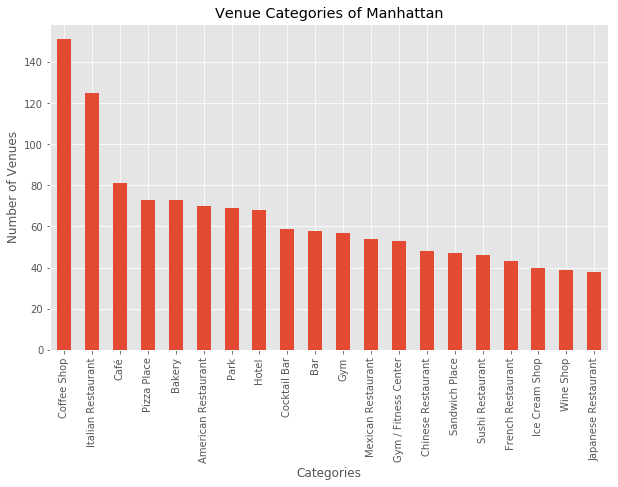

In [25]:
df_nyc_cat = df_manhattan_cat.head(20)
df_nyc_cat.plot(kind='bar', figsize=(10, 6))

plt.xlabel('Categories') # add to x-label to the plot
plt.ylabel('Number of Venues') # add y-label to the plot
plt.title('Venue Categories of Manhattan') # add title to the plot

plt.show()

###  Get Numerical Comparison of Grouped Venues

In [39]:
# one hot encoding
manhattan_onehot = pd.get_dummies(manhattan_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
manhattan_onehot['Neighborhood'] = manhattan_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [manhattan_onehot.columns[-1]] + list(manhattan_onehot.columns[:-1])
manhattan_onehot = manhattan_onehot[fixed_columns]

manhattan_onehot.head()
manhattan_onehot.shape

(3172, 327)

In [40]:
manhattan_grouped = manhattan_onehot.groupby('Neighborhood').mean().reset_index()
manhattan_grouped

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Bookstore,College Cafeteria,College Theater,Comedy Club,Community Center,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Eye Doctor,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Financial or Legal Service,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Moving Target,Museum,Music School,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Outdoor Sculpture,Outdoors & Recreation,Paella Restaurant,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Studio,Physical Therapist,Piano Bar,Pie Shop,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pub,Public Art,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,River,Rock Climbing Spot,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skate Park,Smoke Shop,Smoothie Shop,Snack Place,Soba Restaurant,Soccer Field,Social Club,Soup Place,South American Resta

### Top Venues

In [41]:
num_top_venues = 5

for hood in manhattan_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = manhattan_grouped[manhattan_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Battery Park City----
           venue  freq
0           Park  0.11
1          Hotel  0.07
2            Gym  0.05
3    Coffee Shop  0.05
4  Shopping Mall  0.04


----Carnegie Hill----
            venue  freq
0     Coffee Shop  0.08
1            Café  0.05
2     Yoga Studio  0.03
3             Gym  0.03
4  Cosmetics Shop  0.03


----Central Harlem----
                 venue  freq
0   African Restaurant  0.07
1  American Restaurant  0.05
2   Seafood Restaurant  0.05
3                  Bar  0.05
4    French Restaurant  0.05


----Chelsea----
                 venue  freq
0          Coffee Shop  0.09
1          Art Gallery  0.05
2  American Restaurant  0.04
3                Hotel  0.03
4   Italian Restaurant  0.03


----Chinatown----
                   venue  freq
0     Chinese Restaurant  0.09
1                 Bakery  0.06
2           Cocktail Bar  0.05
3  Vietnamese Restaurant  0.04
4           Dessert Shop  0.03


----Civic Center----
                  venue  freq
0           Coffee

In [42]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [43]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = manhattan_grouped['Neighborhood']

for ind in np.arange(manhattan_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(manhattan_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Battery Park City,Park,Hotel,Coffee Shop,Gym,Shopping Mall,Memorial Site,Gourmet Shop,Playground,Plaza,Sandwich Place
1,Carnegie Hill,Coffee Shop,Café,Yoga Studio,Bookstore,Wine Shop,Pizza Place,Gym,Gym / Fitness Center,Cosmetics Shop,French Restaurant
2,Central Harlem,African Restaurant,French Restaurant,Seafood Restaurant,Bar,Chinese Restaurant,Cosmetics Shop,American Restaurant,Café,Grocery Store,Event Space
3,Chelsea,Coffee Shop,Art Gallery,American Restaurant,Seafood Restaurant,Italian Restaurant,Hotel,Bakery,Ice Cream Shop,Nightclub,French Restaurant
4,Chinatown,Chinese Restaurant,Bakery,Cocktail Bar,Vietnamese Restaurant,Optical Shop,Salon / Barbershop,Spa,American Restaurant,Dessert Shop,Sandwich Place


In [50]:
nyc_venues_sorted = neighborhoods_venues_sorted.copy()
nyc_venues_sorted.drop(['Neighborhood'], axis=1, inplace=True)
nyc_venues_sorted.head()

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Park,Hotel,Coffee Shop,Gym,Shopping Mall,Memorial Site,Gourmet Shop,Playground,Plaza,Sandwich Place
1,Coffee Shop,Café,Yoga Studio,Bookstore,Wine Shop,Pizza Place,Gym,Gym / Fitness Center,Cosmetics Shop,French Restaurant
2,African Restaurant,French Restaurant,Seafood Restaurant,Bar,Chinese Restaurant,Cosmetics Shop,American Restaurant,Café,Grocery Store,Event Space
3,Coffee Shop,Art Gallery,American Restaurant,Seafood Restaurant,Italian Restaurant,Hotel,Bakery,Ice Cream Shop,Nightclub,French Restaurant
4,Chinese Restaurant,Bakery,Cocktail Bar,Vietnamese Restaurant,Optical Shop,Salon / Barbershop,Spa,American Restaurant,Dessert Shop,Sandwich Place


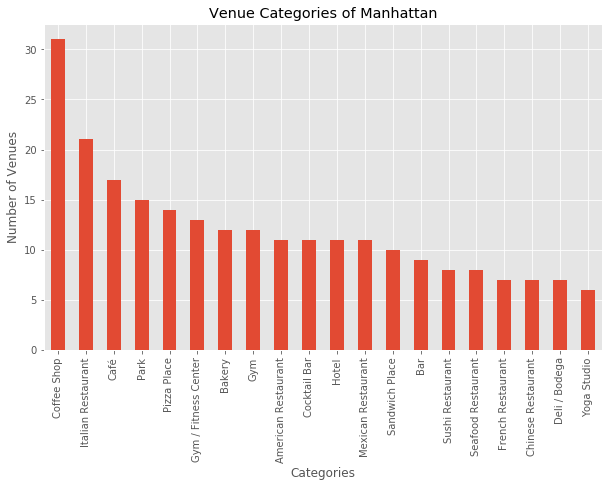

In [53]:
nyc_venues_sorted1 = nyc_venues_sorted.stack().value_counts().head(20)
nyc_venues_sorted1.plot(kind='bar', figsize=(10, 6))

plt.xlabel('Categories') # add to x-label to the plot
plt.ylabel('Number of Venues') # add y-label to the plot
plt.title('Venue Categories of Manhattan') # add title to the plot

plt.show()

## Cluster Neighborhoods into 5 Clusters

In [54]:
# set number of clusters
kclusters = 5

manhattan_grouped_clustering = manhattan_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(manhattan_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 2, 1, 2, 1, 2, 1, 0, 1, 2], dtype=int32)

In [55]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

manhattan_merged = manhattan_data

manhattan_merged = manhattan_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

manhattan_merged.head() # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Manhattan,Marble Hill,40.876551,-73.910660,4,Coffee Shop,Discount Store,Gym,Yoga Studio,Big Box Store,Seafood Restaurant,Tennis Stadium,Supplement Shop,Sandwich Place,Steakhouse
1,Manhattan,Chinatown,40.715618,-73.994279,1,Chinese Restaurant,Bakery,Cocktail Bar,Vietnamese Restaurant,Optical Shop,Salon / Barbershop,Spa,American Restaurant,Dessert Shop,Sandwich Place
2,Manhattan,Washington Heights,40.851903,-73.936900,0,Café,Bakery,Chinese Restaurant,Mobile Phone Shop,Bank,Supermarket,Coffee Shop,Spanish Restaurant,Park,Deli / Bodega
3,Manhattan,Inwood,40.867684,-73.921210,0,Mexican Restaurant,Café,Lounge,Restaurant,Spanish Restaurant,Frozen Yogurt Shop,Park,Bakery,Caribbean Restaurant,Chinese Restaurant
4,Manhattan,Hamilton Heights,40.823604,-73.949688,0,Pizza Place,Coffee Shop,Café,Deli / Bodega,Mexican Restaurant,Sushi Restaurant,Park,Bakery,Sandwich Place,Yoga Studio


### Generate a Map

In [56]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(manhattan_merged['Latitude'], manhattan_merged['Longitude'], manhattan_merged['Neighborhood'], manhattan_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Analyze Each Cluster

In [57]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 0, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Washington Heights,Café,Bakery,Chinese Restaurant,Mobile Phone Shop,Bank,Supermarket,Coffee Shop,Spanish Restaurant,Park,Deli / Bodega
3,Inwood,Mexican Restaurant,Café,Lounge,Restaurant,Spanish Restaurant,Frozen Yogurt Shop,Park,Bakery,Caribbean Restaurant,Chinese Restaurant
4,Hamilton Heights,Pizza Place,Coffee Shop,Café,Deli / Bodega,Mexican Restaurant,Sushi Restaurant,Park,Bakery,Sandwich Place,Yoga Studio
5,Manhattanville,Coffee Shop,Deli / Bodega,Italian Restaurant,Seafood Restaurant,Mexican Restaurant,Bar,Climbing Gym,Cuban Restaurant,Scenic Lookout,Japanese Curry Restaurant
7,East Harlem,Mexican Restaurant,Bakery,Thai Restaurant,Deli / Bodega,Sandwich Place,Latin American Restaurant,Pizza Place,Grocery Store,Seafood Restaurant,Liquor Store
36,Tudor City,Park,Mexican Restaurant,Café,Coffee Shop,Deli / Bodega,Diner,Spanish Restaurant,Sushi Restaurant,Garden,Gym


In [58]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 1, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Chinatown,Chinese Restaurant,Bakery,Cocktail Bar,Vietnamese Restaurant,Optical Shop,Salon / Barbershop,Spa,American Restaurant,Dessert Shop,Sandwich Place
6,Central Harlem,African Restaurant,French Restaurant,Seafood Restaurant,Bar,Chinese Restaurant,Cosmetics Shop,American Restaurant,Café,Grocery Store,Event Space
9,Yorkville,Italian Restaurant,Gym,Bar,Coffee Shop,Sushi Restaurant,Diner,Pizza Place,Japanese Restaurant,Mexican Restaurant,Wine Shop
10,Lenox Hill,Coffee Shop,Sushi Restaurant,Pizza Place,Italian Restaurant,Cocktail Bar,Café,Gym / Fitness Center,Gym,Burger Joint,Salon / Barbershop
11,Roosevelt Island,Park,Monument / Landmark,Farmers Market,Liquor Store,Greek Restaurant,Metro Station,Supermarket,Bubble Tea Shop,Bus Line,Food & Drink Shop
12,Upper West Side,Italian Restaurant,Coffee Shop,Indian Restaurant,Wine Bar,Bakery,Mediterranean Restaurant,Bar,Seafood Restaurant,Thai Restaurant,Ice Cream Shop
13,Lincoln Square,Plaza,Theater,Italian Restaurant,Gym / Fitness Center,Concert Hall,Performing Arts Venue,Café,Indie Movie Theater,Wine Shop,Clothing Store
14,Clinton,Gym / Fitness Center,Theater,Cocktail Bar,American Restaurant,Sandwich Place,Italian Restaurant,Coffee Shop,Gym,Spa,Hotel
16,Murray Hill,Sandwich Place,Coffee Shop,American Restaurant,Japanese Restaurant,Bar,Hotel,Gym / Fitness Center,Pizza Place,Burger Joint,Jewish Restaurant
18,Greenwich Village,Italian Restaurant,Sushi Restaurant,Café,Clothing Store,Indian Restaurant,Gym,Ice Cream Shop,Chinese Restaurant,Gourmet Shop,Dessert Shop


In [59]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 2, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,Upper East Side,Italian Restaurant,Coffee Shop,Bakery,Gym / Fitness Center,Yoga Studio,Pizza Place,Spa,French Restaurant,Juice Bar,Exhibit
15,Midtown,Coffee Shop,Hotel,Clothing Store,Theater,Sporting Goods Shop,Bakery,Bookstore,Steakhouse,Sandwich Place,Sushi Restaurant
17,Chelsea,Coffee Shop,Art Gallery,American Restaurant,Seafood Restaurant,Italian Restaurant,Hotel,Bakery,Ice Cream Shop,Nightclub,French Restaurant
21,Tribeca,Park,Italian Restaurant,Wine Bar,Café,Spa,American Restaurant,Coffee Shop,Greek Restaurant,Poke Place,Basketball Court
23,Soho,Italian Restaurant,Clothing Store,Coffee Shop,Mediterranean Restaurant,Boutique,Salon / Barbershop,Hotel,Bakery,Seafood Restaurant,Dessert Shop
28,Battery Park City,Park,Hotel,Coffee Shop,Gym,Shopping Mall,Memorial Site,Gourmet Shop,Playground,Plaza,Sandwich Place
29,Financial District,Coffee Shop,Pizza Place,Café,Cocktail Bar,Steakhouse,Gym / Fitness Center,Italian Restaurant,Gym,Park,American Restaurant
30,Carnegie Hill,Coffee Shop,Café,Yoga Studio,Bookstore,Wine Shop,Pizza Place,Gym,Gym / Fitness Center,Cosmetics Shop,French Restaurant
32,Civic Center,Coffee Shop,Hotel,Cocktail Bar,French Restaurant,Gym / Fitness Center,Yoga Studio,Café,Spa,Italian Restaurant,Park
33,Midtown South,Korean Restaurant,Hotel,Japanese Restaurant,Dessert Shop,Cosmetics Shop,Coffee Shop,Gym / Fitness Center,Gastropub,Burger Joint,Café


In [60]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 3, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
37,Stuyvesant Town,Park,Bar,Baseball Field,Pet Service,Gas Station,Boat or Ferry,Bistro,Farmers Market,Gym / Fitness Center,Cocktail Bar


In [61]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 4, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Marble Hill,Coffee Shop,Discount Store,Gym,Yoga Studio,Big Box Store,Seafood Restaurant,Tennis Stadium,Supplement Shop,Sandwich Place,Steakhouse


# Toronto Analysis

## Obtain Toronto Data

In [71]:
url_tor = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text
sp_tor = BeautifulSoup(url_tor, 'lxml')

In [74]:
table_post = sp_tor.find('table')
fields = table_post.find_all('td')

postcode = []
borough = []
neighbourhood = []

for i in range(0, len(fields), 3):
    postcode.append(fields[i].text.strip())
    borough.append(fields[i+1].text.strip())
    neighbourhood.append(fields[i+2].text.strip())
        
df = pd.DataFrame(data=[postcode, borough, neighbourhood]).transpose()
df.columns = ['Postcode', 'Borough', 'Neighbourhood']
df.head()

,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


In [76]:
df_n = df.groupby(['Postcode', 'Borough'])['Neighbourhood'].apply(', '.join).reset_index()
df_n.columns = ['Postcode', 'Borough', 'Neighbourhood']
df_n["Borough"].replace('Not assigned', np.nan, inplace = True)
df_n.dropna(subset=['Borough'], inplace=True)
df_n["Neighbourhood"].replace('Not assigned', np.nan, inplace = True)
df_n.shape

(103, 3)

In [77]:
df_n.head()

,Postcode,Borough,Neighbourhood
1,M1B,Scarborough,"Malvern, Rouge"
2,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
3,M1E,Scarborough,"Guildwood, Morningside, West Hill"
4,M1G,Scarborough,Woburn
5,M1H,Scarborough,Cedarbrae


In [78]:
df_geo = pd.read_csv('http://cocl.us/Geospatial_data')
df_geo.columns = ['Postcode', 'Latitude', 'Longitude']

In [79]:
df_geo.head()

,Postcode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [80]:
df_postcode = pd.merge(df_n, df_geo, on=['Postcode'], how='inner')
df_final = df_postcode[['Borough', 'Neighbourhood', 'Postcode', 'Latitude', 'Longitude']].copy()
df_final.head()

,Borough,Neighbourhood,Postcode,Latitude,Longitude
0,Scarborough,"Malvern, Rouge",M1B,43.806686,-79.194353
1,Scarborough,"Rouge Hill, Port Union, Highland Creek",M1C,43.784535,-79.160497
2,Scarborough,"Guildwood, Morningside, West Hill",M1E,43.763573,-79.188711
3,Scarborough,Woburn,M1G,43.770992,-79.216917
4,Scarborough,Cedarbrae,M1H,43.773136,-79.239476


## Toronto Map

In [81]:
address = 'Toronto, Canada'

geolocator = Nominatim(user_agent="canada_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [82]:
toronto_map = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_final['Latitude'], df_final['Longitude'], df_final['Borough'], df_final['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='green',
        fill=True,
        fill_color='#3199cc',
        fill_opacity=0.3,
        parse_html=False).add_to(toronto_map)  
    
toronto_map

## Toronto Venues

In [83]:
toronto_venues = getNearbyVenues(names=df_final['Neighbourhood'],
                                   latitudes=df_final['Latitude'],
                                   longitudes=df_final['Longitude']
                                  )

Malvern, Rouge
Rouge Hill, Port Union, Highland Creek
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
Kennedy Park, Ionview, East Birchmount Park
Golden Mile, Clairlea, Oakridge
Cliffside, Cliffcrest, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Wexford Heights, Scarborough Town Centre
Wexford, Maryvale
Agincourt
Clarks Corners, Tam O'Shanter, Sullivan
Milliken, Agincourt North, Steeles East, L'Amoreaux East
Steeles West, L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
York Mills, Silver Hills
Willowdale, Newtonbrook
Willowdale, Willowdale East
York Mills West
Willowdale, Willowdale West
Parkwoods
Don Mills
Don Mills
Bathurst Manor, Wilson Heights, Downsview North
Northwood Park, York University
Downsview
Downsview
Downsview
Downsview
Victoria Village
Parkview Hill, Woodbine Gardens
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto, Broadview North (Old East York)
The Danforth West, 

In [84]:
print(toronto_venues.shape)
toronto_venues.head()

(2124, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Malvern, Rouge",43.806686,-79.194353,Wendy’s,43.807448,-79.199056,Fast Food Restaurant
1,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,Chris Effects Painting,43.784343,-79.163742,Construction & Landscaping
2,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
3,"Guildwood, Morningside, West Hill",43.763573,-79.188711,RBC Royal Bank,43.766790,-79.191151,Bank
4,"Guildwood, Morningside, West Hill",43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store


In [85]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,4,4,4,4,4,4
"Alderwood, Long Branch",6,6,6,6,6,6
"Bathurst Manor, Wilson Heights, Downsview North",22,22,22,22,22,22
Bayview Village,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",25,25,25,25,25,25
Berczy Park,58,58,58,58,58,58
"Birch Cliff, Cliffside West",4,4,4,4,4,4
"Brockton, Parkdale Village, Exhibition Place",24,24,24,24,24,24
"Business reply mail Processing Centre, South Central Letter Processing Plant Toronto",14,14,14,14,14,14


In [86]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 269 uniques categories.


In [92]:
df_tor_cat = toronto_venues["Venue Category"].value_counts()
df_tor_cat.head()

Coffee Shop                      189
Café                             100
Restaurant                        67
Park                              51
Pizza Place                       50
Sandwich Place                    42
Italian Restaurant                42
Hotel                             41
Japanese Restaurant               40
Bakery                            38
Clothing Store                    37
Gym                               35
Bar                               32
Sushi Restaurant                  31
Grocery Store                     30
Pub                               28
American Restaurant               28
Bank                              26
Fast Food Restaurant              23
Breakfast Spot                    22
Seafood Restaurant                22
Thai Restaurant                   20
Pharmacy                          18
Ice Cream Shop                    18
Beer Bar                          18
Diner                             17
Vegetarian / Vegan Restaurant     17
G

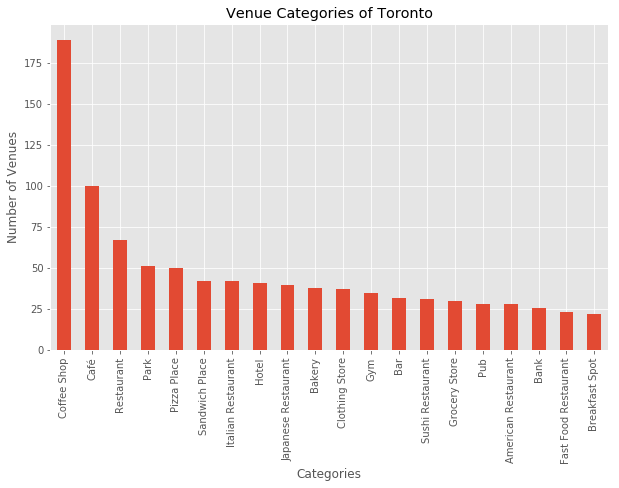

In [101]:
df_tor_cat1 = df_tor_cat.head(20)
df_tor_cat1.plot(kind='bar', figsize=(10, 6))

plt.xlabel('Categories') # add to x-label to the plot
plt.ylabel('Number of Venues') # add y-label to the plot
plt.title('Venue Categories of Toronto') # add title to the plot

plt.show()

In [93]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Yoga Studio,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Rental / Bike Share,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Lawyer,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Market,Martial Arts School,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [94]:
toronto_onehot.shape

(2124, 269)

In [95]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Yoga Studio,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Rental / Bike Share,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Lawyer,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Market,Martial Arts School,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,Agincourt,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00

In [96]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Agincourt----
                       venue  freq
0                     Lounge  0.25
1  Latin American Restaurant  0.25
2             Breakfast Spot  0.25
3               Skating Rink  0.25
4              Metro Station  0.00


----Alderwood, Long Branch----
            venue  freq
0     Pizza Place  0.33
1             Gym  0.17
2  Sandwich Place  0.17
3     Coffee Shop  0.17
4             Pub  0.17


----Bathurst Manor, Wilson Heights, Downsview North----
              venue  freq
0       Coffee Shop  0.09
1              Bank  0.09
2          Pharmacy  0.05
3        Restaurant  0.05
4  Sushi Restaurant  0.05


----Bayview Village----
                 venue  freq
0                 Café  0.25
1                 Bank  0.25
2  Japanese Restaurant  0.25
3   Chinese Restaurant  0.25
4          Yoga Studio  0.00


----Bedford Park, Lawrence Manor East----
                venue  freq
0      Sandwich Place  0.08
1          Restaurant  0.08
2  Italian Restaurant  0.08
3         Coffee Shop  0.

In [114]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Breakfast Spot,Latin American Restaurant,Lounge,Skating Rink,Doner Restaurant,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run
1,"Alderwood, Long Branch",Pizza Place,Gym,Coffee Shop,Pub,Sandwich Place,Discount Store,Department Store,Dessert Shop,Dim Sum Restaurant,Diner
2,"Bathurst Manor, Wilson Heights, Downsview North",Coffee Shop,Bank,Gift Shop,Fried Chicken Joint,Sandwich Place,Bridal Shop,Diner,Restaurant,Deli / Bodega,Supermarket
3,Bayview Village,Japanese Restaurant,Café,Bank,Chinese Restaurant,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run,Women's Store
4,"Bedford Park, Lawrence Manor East",Restaurant,Sandwich Place,Coffee Shop,Italian Restaurant,Breakfast Spot,Indian Restaurant,Butcher,Café,Sushi Restaurant,Cupcake Shop
5,Berczy Park,Coffee Shop,Cheese Shop,Farmers Market,Café,Seafood Restaurant,Restaurant,Cocktail Bar,Beer Bar,Bakery,Hotel
6,"Birch Cliff, Cliffside West",General Entertainment,Café,College Stadium,Skating Rink,Dog Run,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center
7,"Brockton, Parkdale Village, Exhibition Place",Café,Nightclub,Coffee Shop,Breakfast Spot,Bakery,Performing Arts Venue,Pet Store,Convenience Store,Climbing Gym,Restaurant
8,"Business reply mail Processing Centre, South C...",Light Rail Station,Garden,Park,Pizza Place,Comic Shop,Restaurant,Burrito Place,Brewery,Skate Park,Farmers Market
9,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Service,Airport Lounge,Sculpture Garden,Plane,Boutique,Rental Car Location,Airport,Airport Food Court,Airport Gate,Airport Terminal


In [98]:
tor_venues_sorted = neighborhoods_venues_sorted.copy()
tor_venues_sorted.drop(['Neighborhood'], axis=1, inplace=True)
tor_venues_sorted.head()

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Breakfast Spot,Latin American Restaurant,Lounge,Skating Rink,Doner Restaurant,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run
1,Pizza Place,Gym,Coffee Shop,Pub,Sandwich Place,Discount Store,Department Store,Dessert Shop,Dim Sum Restaurant,Diner
2,Coffee Shop,Bank,Gift Shop,Fried Chicken Joint,Sandwich Place,Bridal Shop,Diner,Restaurant,Deli / Bodega,Supermarket
3,Japanese Restaurant,Café,Bank,Chinese Restaurant,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run,Women's Store
4,Restaurant,Sandwich Place,Coffee Shop,Italian Restaurant,Breakfast Spot,Indian Restaurant,Butcher,Café,Sushi Restaurant,Cupcake Shop


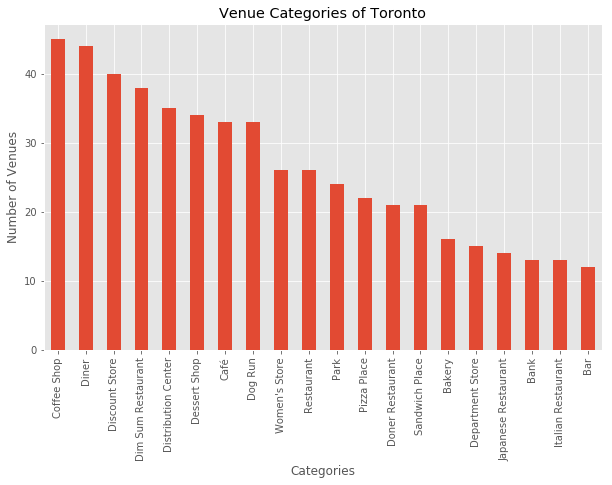

In [100]:
tor_venues_sorted1 = tor_venues_sorted.stack().value_counts().head(20)
tor_venues_sorted1.plot(kind='bar', figsize=(10, 6))

plt.xlabel('Categories') # add to x-label to the plot
plt.ylabel('Number of Venues') # add y-label to the plot
plt.title('Venue Categories of Toronto') # add title to the plot

plt.show()

## Cluster Neighborhoods

In [198]:
# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([2, 0, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

In [221]:
# add clustering labels
# neighborhoods_venues_sorted.insert(0, "Cluster Labels", kmeans.labels_)
df_final['Borough'].replace('Not assigned', np.nan, inplace=True)
df_final.dropna(subset=['Borough'], inplace=True)

neighborhoods_venues_sorted['Cluster Labels'].replace(np.nan, 'Nan', inplace=True)
neighborhoods_venues_sorted.dropna(axis = 0, subset=['Cluster Labels'], inplace=True)
# neighborhoods_venues_sorted.drop([16, 20, ])

toronto_merged = df_final


# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighbourhood')
toronto_merged['Cluster Labels'].replace('Nan', np.nan, inplace=True)
toronto_merged.dropna(axis = 0, subset=['Cluster Labels'], inplace=True)

toronto_merged # check the last columns!

(99, 16)

In [222]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighbourhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[round(cluster-1)],
        fill=True,
        fill_color=rainbow[round(cluster-1)],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# Seoul Data

## Obtain Seoul Data

In [62]:
url_seoul = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_in_South_Korea#Seoul').text
sp_seoul = BeautifulSoup(url_seoul, 'lxml')

In [63]:
table_post_seoul = sp_seoul.find('table')
fields_seoul = table_post_seoul.find_all('td')

postcode = []
district = []

for i in range(0, len(fields_seoul), 4):
    postcode.append(fields_seoul[i].text.strip())
    district.append(fields_seoul[i+1].text.strip())
        
df_seoul = pd.DataFrame(data=[postcode, district]).transpose()
df_seoul.columns = ['Postcode', 'District']
df_seoul.tail()

,Postcode,District
21,079NN ~ 081NN,Yangcheon District
22,082NN ~ 084NN,Guro District
23,085NN ~ 086NN,Geumcheon District
24,087NN ~ 089NN,Gwanak District
25,090NN ~ 099NN,(reserved)


In [64]:
df_seoul["District"].replace('(reserved)', np.nan, inplace = True)
df_seoul.dropna(subset=['District'], inplace=True)
df_seoul.tail()

,Postcode,District
20,075NN ~ 078NN,Gangseo District
21,079NN ~ 081NN,Yangcheon District
22,082NN ~ 084NN,Guro District
23,085NN ~ 086NN,Geumcheon District
24,087NN ~ 089NN,Gwanak District


In [158]:
latitude_seoul = []
longitude_seoul = []
for i in range(0, len(df_seoul)):
    # initialize your variable to None

    address = (df_seoul['District'][i].split()[0])+', Seoul, South Korea'

    geolocator = Nominatim(user_agent="seoul_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    print('The geograpical coordinate of '+address+' are {}, {}.'.format(latitude, longitude))

    latitude_seoul.append(latitude)
    longitude_seoul.append(longitude)

The geograpical coordinate of Gangbuk, Seoul, South Korea are 37.6379932, 127.0257229.
The geograpical coordinate of Dobong, Seoul, South Korea are 37.6792077, 127.0455468.
The geograpical coordinate of Nowon, Seoul, South Korea are 37.6555152, 127.0603126.
The geograpical coordinate of Jungnang, Seoul, South Korea are 37.614069, 127.10360983678746.
The geograpical coordinate of Dongdaemun, Seoul, South Korea are 37.5712838, 127.0089811.
The geograpical coordinate of Seongbuk, Seoul, South Korea are 37.5937602, 127.0039977.
The geograpical coordinate of Jongno, Seoul, South Korea are 37.5703834, 126.9901528.
The geograpical coordinate of Eunpyeong, Seoul, South Korea are 37.610513, 126.9090868.
The geograpical coordinate of Seodaemun, Seoul, South Korea are 37.5657953, 126.9666351.
The geograpical coordinate of Mapo, Seoul, South Korea are 37.5396369, 126.9459929.
The geograpical coordinate of Yongsan, Seoul, South Korea are 37.5301906, 126.9651428.
The geograpical coordinate of Jung, 

In [159]:
df_seoul["Latitude"] = latitude_seoul
df_seoul["Longitude"] = longitude_seoul
df_seoul.head()

,Postcode,District,Latitude,Longitude
0,010NN ~ 012NN,Gangbuk District,37.637993,127.025723
1,013NN ~ 015NN,Dobong District,37.679208,127.045547
2,015NN ~ 019NN,Nowon District,37.655515,127.060313
3,020NN ~ 023NN,Jungnang District,37.614069,127.103610
4,024NN ~ 026NN,Dongdaemun District,37.571284,127.008981


In [131]:
address = 'Seoul, South Korea'

geolocator = Nominatim(user_agent="seoul_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Seoul are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Seoul are 37.5666791, 126.9782914.


In [163]:
seoul_map = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, district in zip(df_seoul['Latitude'], df_seoul['Longitude'], df_seoul['District']):
    label = '{}'.format(district)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='green',
        fill=True,
        fill_color='#3199cc',
        fill_opacity=0.3,
        parse_html=False).add_to(seoul_map)  
    
seoul_map

In [164]:
seoul_venues = getNearbyVenues(names=df_seoul['District'],
                                   latitudes=df_seoul['Latitude'],
                                   longitudes=df_seoul['Longitude']
                                  )

Gangbuk District
Dobong District
Nowon District
Jungnang District
Dongdaemun District
Seongbuk District
Jongno District
Eunpyeong District
Seodaemun District
Mapo District
Yongsan District
Jung District
Seongdong District
Gwangjin District
Gangdong District
Songpa District
Gangnam District
Seocho District
Dongjak District
Yeongdeungpo District
Gangseo District
Yangcheon District
Guro District
Geumcheon District
Gwanak District


In [165]:
print(seoul_venues.shape)
seoul_venues.head()

(791, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Gangbuk District,37.637993,127.025723,KYOBO Book Center (교보문고),37.638361,127.026357,Bookstore
1,Gangbuk District,37.637993,127.025723,Starbucks Reserve (스타벅스 리저브),37.639915,127.027408,Coffee Shop
2,Gangbuk District,37.637993,127.025723,황주집,37.640185,127.028198,Korean Restaurant
3,Gangbuk District,37.637993,127.025723,Baskin-Robbins,37.637412,127.025116,Ice Cream Shop
4,Gangbuk District,37.637993,127.025723,Dunkin' (던킨도너츠),37.639233,127.027400,Donut Shop


In [167]:
seoul_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Dobong District,4,4,4,4,4,4
Dongdaemun District,90,90,90,90,90,90
Dongjak District,9,9,9,9,9,9
Eunpyeong District,4,4,4,4,4,4
Gangbuk District,16,16,16,16,16,16
Gangdong District,21,21,21,21,21,21
Gangnam District,100,100,100,100,100,100
Gangseo District,11,11,11,11,11,11
Geumcheon District,4,4,4,4,4,4


In [168]:
print('There are {} uniques categories.'.format(len(seoul_venues['Venue Category'].unique())))

There are 124 uniques categories.


In [174]:
df_seoul_cat = seoul_venues["Venue Category"].value_counts()
df_seoul_cat.head()

Korean Restaurant     129
Coffee Shop            95
BBQ Joint              43
Café                   41
Chinese Restaurant     31
Name: Venue Category, dtype: int64

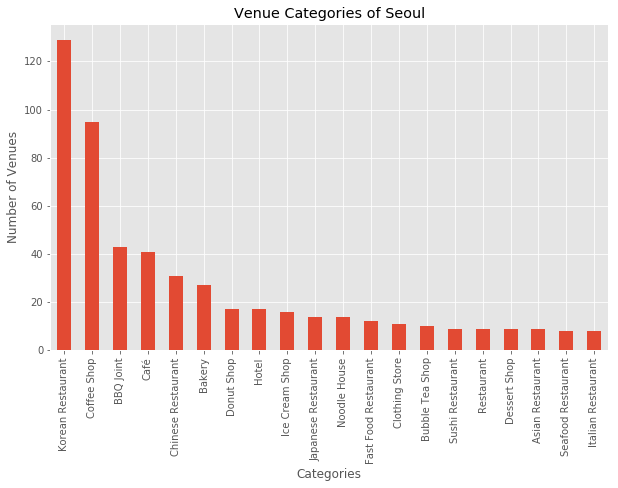

In [175]:
df_seoul_cat1 = df_seoul_cat.head(20)
df_seoul_cat1.plot(kind='bar', figsize=(10, 6))

plt.xlabel('Categories') # add to x-label to the plot
plt.ylabel('Number of Venues') # add y-label to the plot
plt.title('Venue Categories of Seoul') # add title to the plot

plt.show()

In [170]:
# one hot encoding
seoul_onehot = pd.get_dummies(seoul_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
seoul_onehot['Neighborhood'] = seoul_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [seoul_onehot.columns[-1]] + list(seoul_onehot.columns[:-1])
seoul_onehot = seoul_onehot[fixed_columns]

seoul_onehot.head()

,Neighborhood,Accessories Store,American Restaurant,Arcade,Art Gallery,Art Museum,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Bakery,Bar,Bed & Breakfast,Beer Bar,Big Box Store,Boat or Ferry,Bookstore,Bossam/Jokbal Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Bunsik Restaurant,Burger Joint,Bus Line,Bus Station,Bus Stop,Café,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,College Cafeteria,Comfort Food Restaurant,Convenience Store,Cosmetics Shop,Department Store,Dessert Shop,Dim Sum Restaurant,Dive Bar,Donut Shop,Dumpling Restaurant,Duty-free Shop,Electronics Store,Fast Food Restaurant,Food & Drink Shop,Food Court,Fried Chicken Joint,Garden,Gay Bar,Golf Course,Grocery Store,Gukbap Restaurant,Gym,Gym / Fitness Center,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Lebanese Restaurant,Lounge,Market,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Movie Theater,Multiplex,Museum,Music Store,Noodle House,Outdoors & Recreation,Outlet Mall,Park,Pastry Shop,Performing Arts Venue,Pizza Place,Plaza,Pub,Ramen Restaurant,Rental Service,Restaurant,Rock Club,Sake Bar,Salad Place,Samgyetang Restaurant,Sandwich Place,Seafood Restaurant,Shabu-Shabu Restaurant,Shopping Mall,Smoothie Shop,Snack Place,Souvenir Shop,Spa,Speakeasy,Steakhouse,Supermarket,Sushi Restaurant,Tea Room,Thai Restaurant,Theater,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Udon Restaurant,Used Bookstore,Vietnamese Restaurant,Warehouse Store,Waterfall,Wine Bar
0,Gangbuk District,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Gangbuk District,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Gangbuk District,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Gangbuk District,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Gangbuk District,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [172]:
seoul_grouped = seoul_onehot.groupby('Neighborhood').mean().reset_index()
seoul_grouped

,Neighborhood,Accessories Store,American Restaurant,Arcade,Art Gallery,Art Museum,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Bakery,Bar,Bed & Breakfast,Beer Bar,Big Box Store,Boat or Ferry,Bookstore,Bossam/Jokbal Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Bunsik Restaurant,Burger Joint,Bus Line,Bus Station,Bus Stop,Café,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,College Cafeteria,Comfort Food Restaurant,Convenience Store,Cosmetics Shop,Department Store,Dessert Shop,Dim Sum Restaurant,Dive Bar,Donut Shop,Dumpling Restaurant,Duty-free Shop,Electronics Store,Fast Food Restaurant,Food & Drink Shop,Food Court,Fried Chicken Joint,Garden,Gay Bar,Golf Course,Grocery Store,Gukbap Restaurant,Gym,Gym / Fitness Center,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Lebanese Restaurant,Lounge,Market,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Movie Theater,Multiplex,Museum,Music Store,Noodle House,Outdoors & Recreation,Outlet Mall,Park,Pastry Shop,Performing Arts Venue,Pizza Place,Plaza,Pub,Ramen Restaurant,Rental Service,Restaurant,Rock Club,Sake Bar,Salad Place,Samgyetang Restaurant,Sandwich Place,Seafood Restaurant,Shabu-Shabu Restaurant,Shopping Mall,Smoothie Shop,Snack Place,Souvenir Shop,Spa,Speakeasy,Steakhouse,Supermarket,Sushi Restaurant,Tea Room,Thai Restaurant,Theater,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Udon Restaurant,Used Bookstore,Vietnamese Restaurant,Warehouse Store,Waterfall,Wine Bar
0,Dobong District,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.0000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.250000,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.00
1,Dongdaemun District,0.011111,0.000000,0.000000,0.011111,0.011111,0.000000,0.000000,0.00,0.033333,0.022222,0.000000,0.00,0.000000,0.00,0.000000,0.011111,0.011111,0.00,0.0000,0.022222,0.022222,0.000000,0.011111,0.00,0.000000,0.011111,0.022222,0.044444,0.033333,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333,0.00,0.000000,0.022222,0.011111,0.011111,0.000000,0.022222,0.00,0.011111,0.022222,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.011111,0.011111,0.000000,0.00,0.000000,0.011111,0.011111,0.011111,0.022222,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.022222,0.133333,0.000000,0.000000,0.011111,0.022222,0.000000,0.00,0.011111,0.000000,0.011111,0.011111,0.00,0.011111,0.000000,0.011111,0.022222,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.00,0.011111,0.000000,0.011111,0.000000,0.055556,0.000000,0.000000,0.011111,0.000000,0.00,0.022222,0.000000,0.000000,0.011111,0.000000,0.000000,0.00,0.011111,0.000000,0.000000,0.0000,0.000000,0.000000,0.011111,0.000000,0.00
2,Dongjak District,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.111111,0.00,0.000000,0.00,0.111111,0.000000,0.000000,0.00,0.0000,0.000000,0.000000,0.000000,0.000000,0.00,

In [173]:
num_top_venues = 5

for hood in seoul_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = seoul_grouped[seoul_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Dobong District----
               venue  freq
0  Korean Restaurant  0.50
1               Café  0.25
2               Park  0.25
3  Accessories Store  0.00
4      Movie Theater  0.00


----Dongdaemun District----
                venue  freq
0   Korean Restaurant  0.13
1         Coffee Shop  0.10
2       Shopping Mall  0.06
3  Chinese Restaurant  0.04
4        Dessert Shop  0.03


----Dongjak District----
                   venue  freq
0                   Café  0.33
1                   Lake  0.11
2           Intersection  0.11
3  Outdoors & Recreation  0.11
4          Boat or Ferry  0.11


----Eunpyeong District----
               venue  freq
0  Korean Restaurant  0.25
1             Bakery  0.25
2              Plaza  0.25
3           Bus Line  0.25
4             Museum  0.00


----Gangbuk District----
               venue  freq
0         Donut Shop  0.19
1        Coffee Shop  0.19
2  Korean Restaurant  0.12
3            Brewery  0.06
4          BBQ Joint  0.06


----Gangdong District

In [176]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
district_venues_sorted = pd.DataFrame(columns=columns)
district_venues_sorted['Neighborhood'] = seoul_grouped['Neighborhood']

for ind in np.arange(seoul_grouped.shape[0]):
    district_venues_sorted.iloc[ind, 1:] = return_most_common_venues(seoul_grouped.iloc[ind, :], num_top_venues)

district_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Dobong District,Korean Restaurant,Café,Park,Wine Bar,Food & Drink Shop,Convenience Store,Cosmetics Shop,Department Store,Dessert Shop,Dim Sum Restaurant
1,Dongdaemun District,Korean Restaurant,Coffee Shop,Shopping Mall,Chinese Restaurant,Clothing Store,BBQ Joint,Dessert Shop,Fried Chicken Joint,Fast Food Restaurant,Indian Restaurant
2,Dongjak District,Café,Bar,Boat or Ferry,Lake,Intersection,Outdoors & Recreation,Trail,Wine Bar,Electronics Store,Duty-free Shop
3,Eunpyeong District,Bus Line,Bakery,Korean Restaurant,Plaza,Department Store,Dessert Shop,Dim Sum Restaurant,Dive Bar,Food & Drink Shop,Donut Shop
4,Gangbuk District,Coffee Shop,Donut Shop,Korean Restaurant,Ice Cream Shop,BBQ Joint,Multiplex,Fast Food Restaurant,Brewery,Bakery,Bookstore


In [177]:
seoul_venues_sorted = district_venues_sorted.copy()
seoul_venues_sorted.drop(['Neighborhood'], axis=1, inplace=True)
seoul_venues_sorted.head()

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Korean Restaurant,Café,Park,Wine Bar,Food & Drink Shop,Convenience Store,Cosmetics Shop,Department Store,Dessert Shop,Dim Sum Restaurant
1,Korean Restaurant,Coffee Shop,Shopping Mall,Chinese Restaurant,Clothing Store,BBQ Joint,Dessert Shop,Fried Chicken Joint,Fast Food Restaurant,Indian Restaurant
2,Café,Bar,Boat or Ferry,Lake,Intersection,Outdoors & Recreation,Trail,Wine Bar,Electronics Store,Duty-free Shop
3,Bus Line,Bakery,Korean Restaurant,Plaza,Department Store,Dessert Shop,Dim Sum Restaurant,Dive Bar,Food & Drink Shop,Donut Shop
4,Coffee Shop,Donut Shop,Korean Restaurant,Ice Cream Shop,BBQ Joint,Multiplex,Fast Food Restaurant,Brewery,Bakery,Bookstore


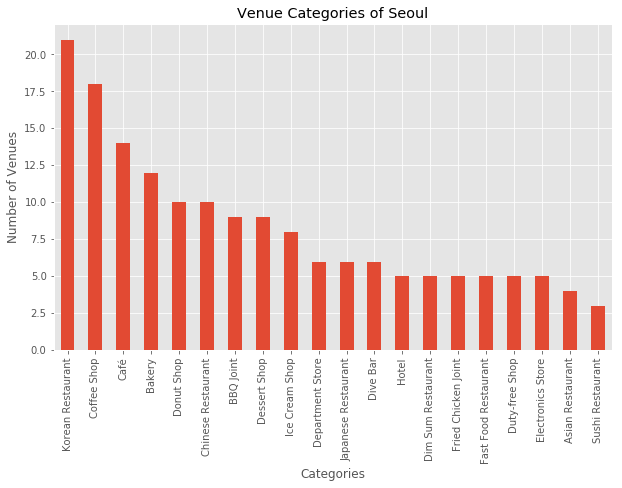

In [178]:
seoul_venues_sorted1 = seoul_venues_sorted.stack().value_counts().head(20)
seoul_venues_sorted1.plot(kind='bar', figsize=(10, 6))

plt.xlabel('Categories') # add to x-label to the plot
plt.ylabel('Number of Venues') # add y-label to the plot
plt.title('Venue Categories of Seoul') # add title to the plot

plt.show()

## Cluster

In [181]:
# set number of clusters
kclusters = 5

seoul_grouped_clustering = seoul_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(seoul_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 2, 2, 1, 2, 2, 2, 1, 3, 2], dtype=int32)

In [186]:
# add clustering labels
#district_venues_sorted.insert(0, "Cluster Labels", kmeans.labels_)

seoul_merged = df_seoul

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
seoul_merged = seoul_merged.join(district_venues_sorted.set_index('Neighborhood'), on='District')

seoul_merged # check the last columns!

,Postcode,District,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,010NN ~ 012NN,Gangbuk District,37.637993,127.025723,2,Coffee Shop,Donut Shop,Korean Restaurant,Ice Cream Shop,BBQ Joint,Multiplex,Fast Food Restaurant,Brewery,Bakery,Bookstore
1,013NN ~ 015NN,Dobong District,37.679208,127.045547,1,Korean Restaurant,Café,Park,Wine Bar,Food & Drink Shop,Convenience Store,Cosmetics Shop,Department Store,Dessert Shop,Dim Sum Restaurant
2,015NN ~ 019NN,Nowon District,37.655515,127.060313,2,Coffee Shop,Korean Restaurant,Donut Shop,Ice Cream Shop,Steakhouse,Fast Food Restaurant,Multiplex,Dessert Shop,Department Store,Café
3,020NN ~ 023NN,Jungnang District,37.614069,127.103610,2,Metro Station,Park,Restaurant,Chinese Restaurant,Buffet,Korean Restaurant,Wine Bar,Dumpling Restaurant,Electronics Store,Duty-free Shop
4,024NN ~ 026NN,Dongdaemun District,37.571284,127.008981,2,Korean Restaurant,Coffee Shop,Shopping Mall,Chinese Restaurant,Clothing Store,BBQ Joint,Dessert Shop,Fried Chicken Joint,Fast Food Restaurant,Indian Restaurant
5,027NN ~ 029NN,Seongbuk District,37.593760,127.003998,1,Korean Restaurant,Noodle House,Coffee Shop,Dessert Shop,Chinese Restaurant,Café,Japanese Restaurant,Bakery,Electronics Store,Duty-free Shop
6,030NN ~ 032NN,Jongno District,37.570383,126.990153,1,Korean Restaurant,Café,Coffee Shop,Hotel,Pub,Restaurant,BBQ Joint,Chinese Restaurant,Beer Bar,Indie Movie Theater
7,033NN ~ 035NN,Eunpyeong District,37.610513,126.909087,1,Bus Line,Bakery,Korean Restaurant,Plaza,Department Store,Dessert Shop,Dim Sum Restaurant,Dive Bar,Food & Drink Shop,Donut Shop
8,036NN ~ 038NN,Seodaemun District,37.565795,126.966635,2,Coffee Shop,Café,Asian Restaurant,Hotel,Korean Restaurant,Chinese Restaurant,Historic Site,Sandwich Place,Snack Place,Dive Bar
9,039NN ~ 042NN,Mapo District,37.539637,126.945993,1,Korean Restaurant,BBQ Joint,Chinese Restaurant,Coffee Shop,Sushi Restaurant,Seafood Restaurant,Hotel,Japanese Restaurant,Noodle House,Café


In [188]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(seoul_merged['Latitude'], seoul_merged['Longitude'], seoul_merged['District'], seoul_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[round(cluster-1)],
        fill=True,
        fill_color=rainbow[round(cluster-1)],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [191]:
seoul_merged.loc[seoul_merged['Cluster Labels'] == 0, seoul_merged.columns[[1] + list(range(5, seoul_merged.shape[1]))]]

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
21,Yangcheon District,Bakery,Ice Cream Shop,Donut Shop,Fast Food Restaurant,Fried Chicken Joint,Convenience Store,Cosmetics Shop,Department Store,Dessert Shop,Dim Sum Restaurant


In [192]:
seoul_merged.loc[seoul_merged['Cluster Labels'] == 1, seoul_merged.columns[[1] + list(range(5, seoul_merged.shape[1]))]]

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Dobong District,Korean Restaurant,Café,Park,Wine Bar,Food & Drink Shop,Convenience Store,Cosmetics Shop,Department Store,Dessert Shop,Dim Sum Restaurant
5,Seongbuk District,Korean Restaurant,Noodle House,Coffee Shop,Dessert Shop,Chinese Restaurant,Café,Japanese Restaurant,Bakery,Electronics Store,Duty-free Shop
6,Jongno District,Korean Restaurant,Café,Coffee Shop,Hotel,Pub,Restaurant,BBQ Joint,Chinese Restaurant,Beer Bar,Indie Movie Theater
7,Eunpyeong District,Bus Line,Bakery,Korean Restaurant,Plaza,Department Store,Dessert Shop,Dim Sum Restaurant,Dive Bar,Food & Drink Shop,Donut Shop
9,Mapo District,Korean Restaurant,BBQ Joint,Chinese Restaurant,Coffee Shop,Sushi Restaurant,Seafood Restaurant,Hotel,Japanese Restaurant,Noodle House,Café
12,Seongdong District,Coffee Shop,Korean Restaurant,Café,Italian Restaurant,Ice Cream Shop,Auto Workshop,Pizza Place,Bunsik Restaurant,Tea Room,Park
13,Gwangjin District,Korean Restaurant,Coffee Shop,Bakery,Gukbap Restaurant,Donut Shop,Café,Ice Cream Shop,Athletics & Sports,Garden,Dessert Shop
17,Seocho District,Korean Restaurant,Coffee Shop,BBQ Joint,Noodle House,Café,Bus Stop,Bakery,Chinese Restaurant,Donut Shop,Vietnamese Restaurant
20,Gangseo District,Café,Korean Restaurant,Coffee Shop,Athletics & Sports,BBQ Joint,Fried Chicken Joint,Dessert Shop,Dim Sum Restaurant,Department Store,Dive Bar
24,Gwanak District,Coffee Shop,Korean Restaurant,Plaza,Café,Bakery,Garden,Fried Chicken Joint,College Cafeteria,Bus Station,Waterfall


In [193]:
seoul_merged.loc[seoul_merged['Cluster Labels'] == 2, seoul_merged.columns[[1] + list(range(5, seoul_merged.shape[1]))]]

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Gangbuk District,Coffee Shop,Donut Shop,Korean Restaurant,Ice Cream Shop,BBQ Joint,Multiplex,Fast Food Restaurant,Brewery,Bakery,Bookstore
2,Nowon District,Coffee Shop,Korean Restaurant,Donut Shop,Ice Cream Shop,Steakhouse,Fast Food Restaurant,Multiplex,Dessert Shop,Department Store,Café
3,Jungnang District,Metro Station,Park,Restaurant,Chinese Restaurant,Buffet,Korean Restaurant,Wine Bar,Dumpling Restaurant,Electronics Store,Duty-free Shop
4,Dongdaemun District,Korean Restaurant,Coffee Shop,Shopping Mall,Chinese Restaurant,Clothing Store,BBQ Joint,Dessert Shop,Fried Chicken Joint,Fast Food Restaurant,Indian Restaurant
8,Seodaemun District,Coffee Shop,Café,Asian Restaurant,Hotel,Korean Restaurant,Chinese Restaurant,Historic Site,Sandwich Place,Snack Place,Dive Bar
10,Yongsan District,Korean Restaurant,Coffee Shop,Hotel,Café,Japanese Restaurant,BBQ Joint,Fast Food Restaurant,Clothing Store,Asian Restaurant,Donut Shop
14,Gangdong District,Bakery,Coffee Shop,Korean Restaurant,Convenience Store,Ice Cream Shop,Bus Stop,Gym / Fitness Center,Gym,Gukbap Restaurant,Japanese Restaurant
15,Songpa District,Coffee Shop,Korean Restaurant,Ice Cream Shop,Bakery,Donut Shop,Bunsik Restaurant,Sushi Restaurant,Garden,Asian Restaurant,Intersection
16,Gangnam District,Korean Restaurant,BBQ Joint,Coffee Shop,Chinese Restaurant,Sushi Restaurant,Italian Restaurant,Café,Japanese Restaurant,Vietnamese Restaurant,Salad Place
18,Dongjak District,Café,Bar,Boat or Ferry,Lake,Intersection,Outdoors & Recreation,Trail,Wine Bar,Electronics Store,Duty-free Shop


In [194]:
seoul_merged.loc[seoul_merged['Cluster Labels'] == 3, seoul_merged.columns[[1] + list(range(5, seoul_merged.shape[1]))]]

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
23,Geumcheon District,Metro Station,Chinese Restaurant,Bus Station,Bakery,Food Court,Cosmetics Shop,Department Store,Dessert Shop,Dim Sum Restaurant,Dive Bar


In [195]:
seoul_merged.loc[seoul_merged['Cluster Labels'] == 4, seoul_merged.columns[[1] + list(range(5, seoul_merged.shape[1]))]]

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,Jung District,Bus Stop,Fried Chicken Joint,Restaurant,Korean Restaurant,BBQ Joint,Dive Bar,Electronics Store,Duty-free Shop,Dumpling Restaurant,Donut Shop
